## Импорт библиотек

In [1]:
!pip install transformers==4.37.2

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
import transformers
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
import sklearn
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from huggingface_hub import login

login(token="hf_q..")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
print(transformers.__version__)

4.37.2


In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
REPLICAS:  8


## Подготовка данных

In [6]:
df = pd.read_csv("Train.csv")
df = df.dropna()
df_test = pd.read_csv("Test.csv")

In [7]:
df = df.drop_duplicates(keep="last")

In [8]:
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

<ipython-input-8-7cdd95144bdd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['categoryEncoded'] = encoder.fit_transform(df['category'])


In [9]:
df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
df['description'] = df['description'].apply(lambda descr: str(descr).lower())
df_test['headline'] = df_test['headline'].apply(lambda headline: str(headline).lower())
df_test['description'] = df_test['description'].apply(lambda descr: str(descr).lower())

<ipython-input-9-a45ab82876b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['headline'] = df['headline'].apply(lambda headline: str(headline).lower())
<ipython-input-9-a45ab82876b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].apply(lambda descr: str(descr).lower())


In [10]:
df['descr_len'] = df['description'].apply(lambda x: len(str(x).split()))
df['headline_len'] = df['headline'].apply(lambda x: len(str(x).split()))
df_test['descr_len'] = df_test['description'].apply(lambda x: len(str(x).split()))
df_test['headline_len'] = df_test['headline'].apply(lambda x: len(str(x).split()))

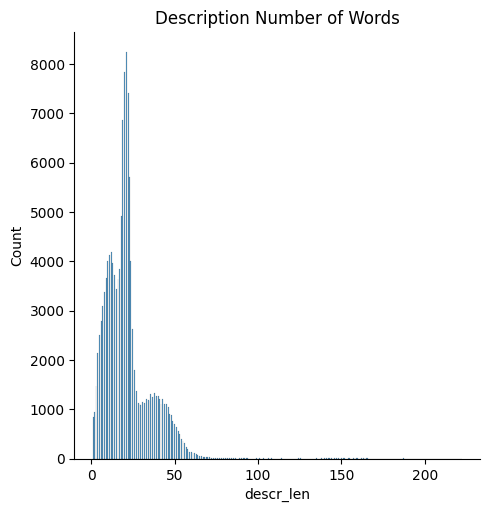

In [11]:
sns.displot(df['descr_len'])
plt.title('Description Number of Words')
plt.show()

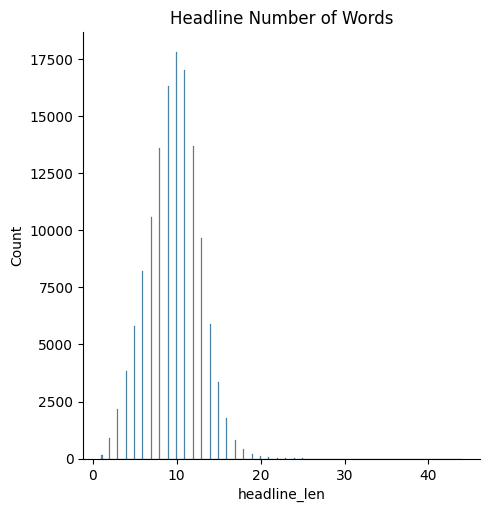

In [12]:
sns.displot(df['headline_len'])
plt.title('Headline Number of Words')
plt.show()

In [13]:
df['description'] = df['headline'] + ' ' + df['description']
df_test['description'] = df_test['headline'] + ' ' + df_test['description']

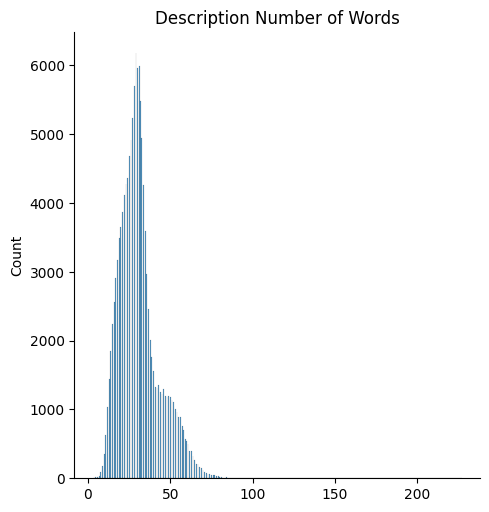

In [14]:
sns.displot(df['headline_len'] + df['descr_len'])
plt.title('Description Number of Words')
plt.show()

In [15]:
print(f"The dataset contains { df.category.nunique() } unique categories")

The dataset contains 42 unique categories


In [16]:
print(f"The dataset contains { df.categoryEncoded.nunique() } unique categories")

The dataset contains 42 unique categories


In [17]:
df.head()

,headline,description,category,categoryEncoded,descr_len,headline_len
0,dolly parton's million-dollar smile and colorf...,dolly parton's million-dollar smile and colorf...,STYLE & BEAUTY,30,22,8
1,does this baby make me look fat?,does this baby make me look fat? most women ar...,PARENTING,22,35,7
3,the fearless power of 'kindsight',the fearless power of 'kindsight' when someone...,WELLNESS,38,34,5
4,new series on 'the secret life of muslims' aim...,new series on 'the secret life of muslims' aim...,RELIGION,26,19,12
5,watch lorde sing in a battle of the bands scho...,watch lorde sing in a battle of the bands scho...,ENTERTAINMENT,10,21,13


In [18]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_token_type_ids=False,
        padding='max_length',
        max_length=maxlen,
        truncation=True
    )

    return np.array(enc_di['input_ids'])



In [19]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [20]:
X_train = df['description']
X_test = df_test['description']
y_train = df['categoryEncoded']

In [21]:
X_train

,description
0,dolly parton's million-dollar smile and colorf...
1,does this baby make me look fat? most women ar...
3,the fearless power of 'kindsight' when someone...
4,new series on 'the secret life of muslims' aim...
5,watch lorde sing in a battle of the bands scho...
...,...
146663,the parents you meet at the pool gotta love th...
146664,justin trudeau invites pope francis to canada ...
146665,mac and cheese with tater tots: an epic casser...
146666,11 reasons you should drink coffee every day r...


In [22]:
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen=80)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes=42)
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen=80)

## Обучение модели

In [23]:
from sklearn.model_selection import train_test_split
Xtrain_encoded, Xval_encoded, ytrain_encoded, yval_encoded = train_test_split(Xtrain_encoded, ytrain_encoded, test_size = 0.15, random_state = 2024, stratify=ytrain_encoded)

In [24]:
from tensorflow.keras import backend as K

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes=42, name='f1_macro', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes

        self.true_positives = self.add_weight(name='tp', shape=(self.num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(self.num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(self.num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)

        y_pred_labels = tf.argmax(y_pred, axis=1)
        y_pred_one_hot = tf.one_hot(y_pred_labels, depth=self.num_classes)
        y_pred_one_hot = tf.cast(y_pred_one_hot, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred_one_hot, axis=0)

        fp = tf.reduce_sum((1 - y_true) * y_pred_one_hot, axis=0)

        fn = tf.reduce_sum(y_true * (1 - y_pred_one_hot), axis=0)

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):

        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1 = 2 * precision * recall / (precision + recall + K.epsilon())
        return tf.reduce_mean(f1)

    def reset_state(self):

        for var in self.variables:
            var.assign(tf.zeros_like(var))


In [25]:
def build_model(transformer, loss='categorical_crossentropy', max_len=512):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]

    x = tf.keras.layers.Dropout(0.3)(cls_token)

    out = tf.keras.layers.Dense(42, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)

    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5), loss=loss, metrics=['accuracy', F1Score()])
    return model

In [26]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len=80)
model.summary()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 80)]              0         
 )                                                               
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   335141888 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 80, 1024),                       
                              pooler_output=(None, 1             
                             024),                               
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                   

In [27]:
BATCH_SIZE = 16*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xtrain_encoded, ytrain_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((Xval_encoded, yval_encoded))
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(Xtest_encoded)
    .batch(BATCH_SIZE)
)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=1e-6)

In [29]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/30


880/880 [==============================] - 479s 364ms/step - loss: 1.3565 - accuracy: 0.6195 - f1_macro: 0.4733 - val_loss: 1.0237 - val_accuracy: 0.6920 - val_f1_macro: 0.5691 - lr: 3.0000e-05
Epoch 2/30
880/880 [==============================] - 296s 336ms/step - loss: 0.9487 - accuracy: 0.7112 - f1_macro: 0.5991 - val_loss: 0.9694 - val_accuracy: 0.7090 - val_f1_macro: 0.6000 - lr: 3.0000e-05
Epoch 3/30
880/880 [==============================] - 295s 335ms/step - loss: 0.7569 - accuracy: 0.7643 - f1_macro: 0.6750 - val_loss: 0.9734 - val_accuracy: 0.7147 - val_f1_macro: 0.6100 - lr: 3.0000e-05
Epoch 4/30
880/880 [==============================] - 293s 332ms/step - loss: 0.5654 - accuracy: 0.8203 - f1_macro: 0.7525 - val_loss: 1.0999 - val_accuracy: 0.7095 - val_f1_macro: 0.6040 - lr: 3.0000e-05
Epoch 5/30
880/880 [==============================] - 304s 345ms/step - loss: 0.3267 - accuracy: 0.8942 - f1_macro: 0.8550 - val_loss: 1.1532 - val_accuracy: 0.7144 - val_f1_macro: 0.6180 - l

In [30]:
preds = model.predict(Xtest_encoded)

1965/1965 [==============================] - 88s 36ms/step


In [31]:
y_pred = np.argmax(preds, axis = 1)

In [32]:
y_pred_labels = encoder.inverse_transform(y_pred)

In [33]:
submission_df = pd.DataFrame({"category": y_pred_labels})

submission_df.to_csv("Submission.csv", index=False)